In [39]:
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import os

In [40]:
class KNNHateSpeechClassifier(BaseEstimator, ClassifierMixin):
    """
    Scikit-learn compatible KNN-based hate speech classifier using sentence-transformer embeddings.
    """

    def __init__(self, threshold=0.25, model_name='all-MiniLM-L6-v2', n_neighbors=5):
        self.threshold = threshold
        self.model_name = model_name
        self.n_neighbors = n_neighbors
        self.embedder = SentenceTransformer(model_name)
        self.scaler = StandardScaler()
        self.knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    def fit(self, X, y):
        """
        Fit the model on text data and labels.
        """
        X_emb = self.embedder.encode(X, show_progress_bar=False)
        X_scaled = self.scaler.fit_transform(X_emb)
        self.knn.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        """
        Predict class probabilities from text inputs.
        """
        X_emb = self.embedder.encode(X, show_progress_bar=False)
        X_scaled = self.scaler.transform(X_emb)
        return self.knn.predict_proba(X_scaled)

    def predict(self, X):
        """
        Predict binary class labels (0 or 1) using threshold.
        """
        probs = self.predict_proba(X)
        return (probs[:, 1] >= self.threshold).astype(int)

    def score(self, X, y):
        """
        Return accuracy score for scikit-learn compatibility.
        """
        return np.mean(self.predict(X) == np.array(y))
    
    def get_embeddings(self, texts, scale=True):
        """
        Return (optionally scaled) SentenceTransformer embeddings.
        """
        embeddings = self.embedder.encode(texts, show_progress_bar=False)
        if scale:
            return self.scaler.fit_transform(embeddings)
        return embeddings

    

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


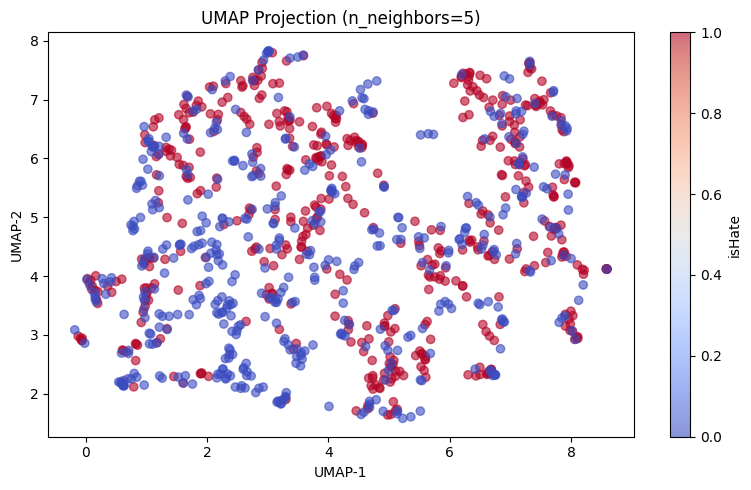

In [38]:
base_dir =  os.getcwd()
input_path = os.path.join(base_dir, "../data/train_data_clean.csv")
df = pd.read_csv(input_path)
texts = df['comment'].tolist()
labels = df['isHate'].tolist()

model_vis = KNNHateSpeechClassifier()
X_emb = model_vis.get_embeddings(texts, scale=False)

k = 5
reducer = umap.UMAP(n_neighbors=k, min_dist=0.01, metric='cosine', random_state=42)
proj = reducer.fit_transform(X_emb)
plt.figure(figsize=(8, 5))
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap="coolwarm", alpha=0.6)
plt.title(f"UMAP Projection (n_neighbors={k})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="isHate")
plt.tight_layout()
plt.show()


In [41]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42)

model = KNNHateSpeechClassifier(threshold=0.25)
param_grid = {'n_neighbors': list(range(1, 10, 1))}
grid = GridSearchCV(model, param_grid, scoring='f1', cv=3)
grid.fit(train_texts, train_labels)
print("Best parameters:", grid.best_params_)
best_model = grid.best_estimator_

preds = best_model.predict(test_texts)
print(classification_report(test_labels, preds))

Best parameters: {'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.95      0.20      0.33       100
           1       0.55      0.99      0.71       100

    accuracy                           0.59       200
   macro avg       0.75      0.59      0.52       200
weighted avg       0.75      0.59      0.52       200



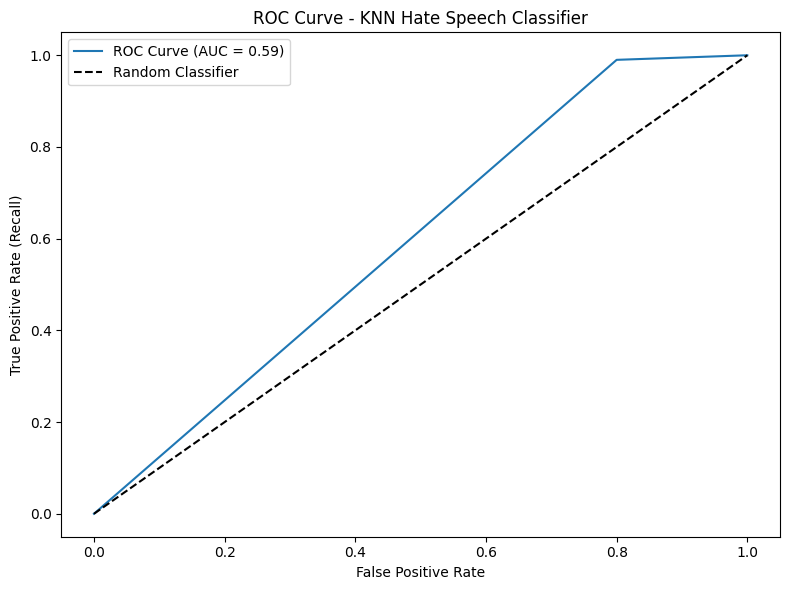

In [42]:
fpr, tpr, _ = roc_curve(test_labels, preds)
roc_auc = roc_auc_score(test_labels, preds)
    
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - KNN Hate Speech Classifier")
plt.legend()
plt.tight_layout()

plt.show()